# EDA  
+ `userID` 사용자의 고유 번호, 총 7,442명의 학생
+ `assessmentItemID` 사용자가 푼 문항의 일련 번호  
+ `testId` 사용자가 푼 문항이 포함된 시험지의 일련 번호 
+ `answerCode` 사용자가 푼 문항의 정답 여부를 담고 있는 이진 (0/1) 데이터
+ `Timestamp` 사용자가 문항을 풀기 시작한 시간 정보  
+ `KnowledgeTag` 사용자가 푼 문항의 고유 태그
## EDA 개요
1. 문항 순서에 따른 정답률
2. 1번 문제 안 푼 시험지 있는 지 확인
3. 유저의 복습 여부 확인(testId 기준)
4. TimeStamp 사용
    * TimeStamp 사용 기준
    * 풀이 소요 시간 정의
    * 문항 풀이 순서에 따른 정답률
    * 풀이 소요 시간 범주화
    * 풀이 시작 시간 사용
    * 풀이 요일 사용
5. 데이터 특이 사항

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns; sns.set_theme(color_codes=True)
# import missingno as msno

In [86]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# 데이터 경로 맞춰주세요!
# 혹시 코랩환경을 사용하신다면 왼쪽 폴더모양 아이콘을 눌러 "train_data.csv"를 드래그&드롭으로 업로드한 후 사용해주세요
DATA_PATH = '../data/train_data.csv'
df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

CPU times: user 3.97 s, sys: 308 ms, total: 4.28 s
Wall time: 4.39 s


In [87]:
def percentile(s):
    return np.sum(s) / len(s)

# 문항 순서에 따른 정답률

In [4]:
df['order_of_prob']=df['assessmentItemID'].apply(lambda x: x[7:])

In [9]:
pronum_group=df.groupby('order_of_prob').agg({
    'userID': 'count',
    'answerCode': percentile
})

In [10]:
pronum_group

,userID,answerCode
order_of_prob,,
001,371755,0.749916
002,370972,0.720062
003,371640,0.687773
004,369705,0.663364
005,360607,0.599134
006,197772,0.555685
007,127121,0.515399
008,67150,0.457156
009,18417,0.481729


# 1번 문제 안 푼 시험지 있는 지 확인

In [11]:
testid_group=df.groupby(['testId','order_of_prob'])['order_of_prob'].count()
testIds = list(df['testId'].unique())
for testID in testIds:
    unique_n =testid_group[testID].nunique()
    # print(testID,unique_n)
    if unique_n>1:
        print(testID)
        print(testid_group[testID])

# 유저의 복습 여부 확인(testId 기준)

In [12]:
testId_user=df[df['order_of_prob']=='001'].loc[:,['userID','testId','assessmentItemID','Timestamp']]
testId_user

,userID,testId,assessmentItemID,Timestamp
0,0,A060000001,A060001001,2020-03-24 00:17:11
6,0,A060000003,A060003001,2020-03-26 05:52:03
13,0,A060000005,A060005001,2020-03-31 05:02:52
20,0,A060000007,A060007001,2020-04-02 04:53:37
27,0,A080000002,A080002001,2020-04-06 00:35:01
...,...,...,...,...
2266562,7440,A050000096,A050096001,2020-08-19 04:57:19
2266567,7440,A030000136,A030136001,2020-09-23 09:19:35
2266572,7440,A030000197,A030197001,2020-10-21 08:31:45
2266577,7441,A030000071,A030071001,2020-06-05 06:46:41


In [14]:
testId_counts = testId_user.groupby('userID')['testId'].agg(['count', 'nunique'])
testId_counts[testId_counts['count']!=testId_counts['nunique']]

,count,nunique
userID,,
1,163,153
6,176,169
16,245,221
34,150,120
40,114,106
...,...,...
6690,8,7
6698,9,7
6858,11,9


# TimeStamp 사용
#### 사용 기준
1. testID가 달라졌을 경우 (고정)
2. testID가 같더라도 이미 풀었는 문항이 나오는 경우
3. 일정 시간을 정하고 기준에 따라 다시 나누기 (15분)

## 풀이 소요 시간 정의

### original과 기준 {1} 사용시 변화 확인

In [5]:
%%time
temp_df = df.copy()
before_testId = '0'
before_userID = 0
before_time = ''
sess_start =0
time_diff=[]
temp_df['solving_session']=0
for i,row in temp_df.iterrows():
    if  before_testId != row['testId']:
        before_testId=row['testId']
        sess_start+=1
    temp_df.at[i, 'solving_session'] = sess_start

CPU times: user 1min 16s, sys: 332 ms, total: 1min 16s
Wall time: 1min 17s


In [6]:
temp_df['order_of_solving'] = temp_df.groupby('solving_session').cumcount() + 1
temp_df['time_diff']= temp_df['Timestamp'].diff(-1).abs()
temp_df['time_diff_session']= temp_df.groupby('solving_session')['Timestamp'].diff(-1).abs()
temp_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,order_of_prob,solving_session,order_of_solving,time_diff,time_diff_session
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,001,1,1,0 days 00:00:03,0 days 00:00:03
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,002,1,2,0 days 00:00:08,0 days 00:00:08
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,003,1,3,0 days 00:00:07,0 days 00:00:07
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,004,1,4,0 days 00:00:07,0 days 00:00:07
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,005,1,5,0 days 00:00:11,0 days 00:00:11
...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,005,374593,5,76 days 18:16:18,NaT
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,001,374594,1,0 days 00:00:11,0 days 00:00:11
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,002,374594,2,0 days 00:00:46,0 days 00:00:46
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,003,374594,3,0 days 00:01:13,0 days 00:01:13


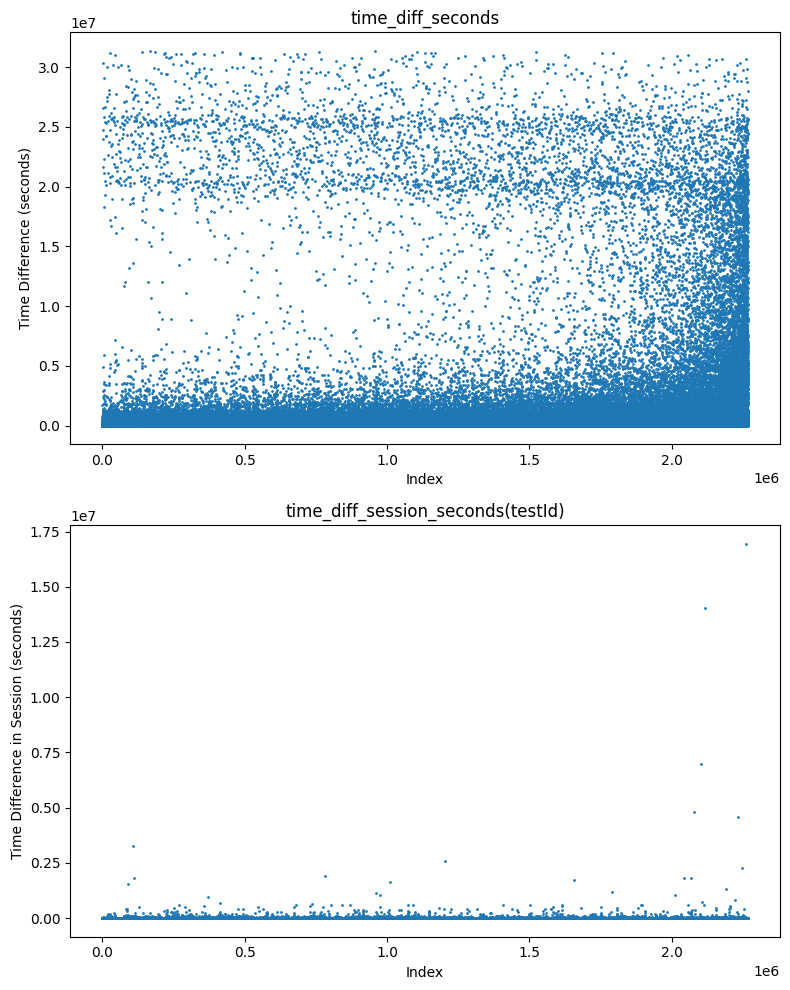

In [17]:
import matplotlib.pyplot as plt

# timedelta를 초 단위로 변환
time_diff_seconds = temp_df['time_diff'].dt.total_seconds()
time_diff_session_seconds = temp_df['time_diff_session'].dt.total_seconds()

fig, ax = plt.subplots(2, 1, figsize=(8, 10))  # 2행 1열의 subplot 생성

# 산점도 그리기
ax[0].scatter(temp_df.index, time_diff_seconds,s=1)
ax[0].set_xlabel('Index')
ax[0].set_ylabel('Time Difference (seconds)')
ax[0].set_title('time_diff_seconds')

ax[1].scatter(temp_df.index, time_diff_session_seconds,s=1)
ax[1].set_xlabel('Index')
ax[1].set_ylabel('Time Difference in Session (seconds)')
ax[1].set_title('time_diff_session_seconds(testId)')

plt.tight_layout()
plt.show()

In [ ]:
ori_temp_df=temp_df

### ver1. 기준 {1,2} 사용

In [19]:
%%time
temp_df = df.copy()
temp_df['order_of_prob']=temp_df['assessmentItemID'].apply(lambda x: x[7:]).astype(int)
before_testId = '0'
before_userID = 0
before_time = ''
sess_start =0
prob_list=[]
temp_df['solving_session']=0
for i,row in temp_df.iterrows():
    if  before_testId != row['testId'] or row['order_of_prob'] in prob_list:
        before_testId=row['testId']
        prob_list=[]
        sess_start+=1
    temp_df.at[i, 'solving_session'] = sess_start
    prob_list.append(row['order_of_prob'])

CPU times: user 1min 26s, sys: 666 ms, total: 1min 26s
Wall time: 1min 27s


In [20]:
temp_df['order_of_solving'] = temp_df.groupby('solving_session').cumcount() + 1
temp_df['time_diff_session']= temp_df.groupby('solving_session')['Timestamp'].diff(-1).abs()
temp_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,order_of_prob,solving_session,order_of_solving,time_diff_session
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,1,1,0 days 00:00:03
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,2,1,2,0 days 00:00:08
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,3,1,3,0 days 00:00:07
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,4,1,4,0 days 00:00:07
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,5,1,5,0 days 00:00:11
...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,5,374882,5,NaT
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,374883,1,0 days 00:00:11
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2,374883,2,0 days 00:00:46
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,3,374883,3,0 days 00:01:13


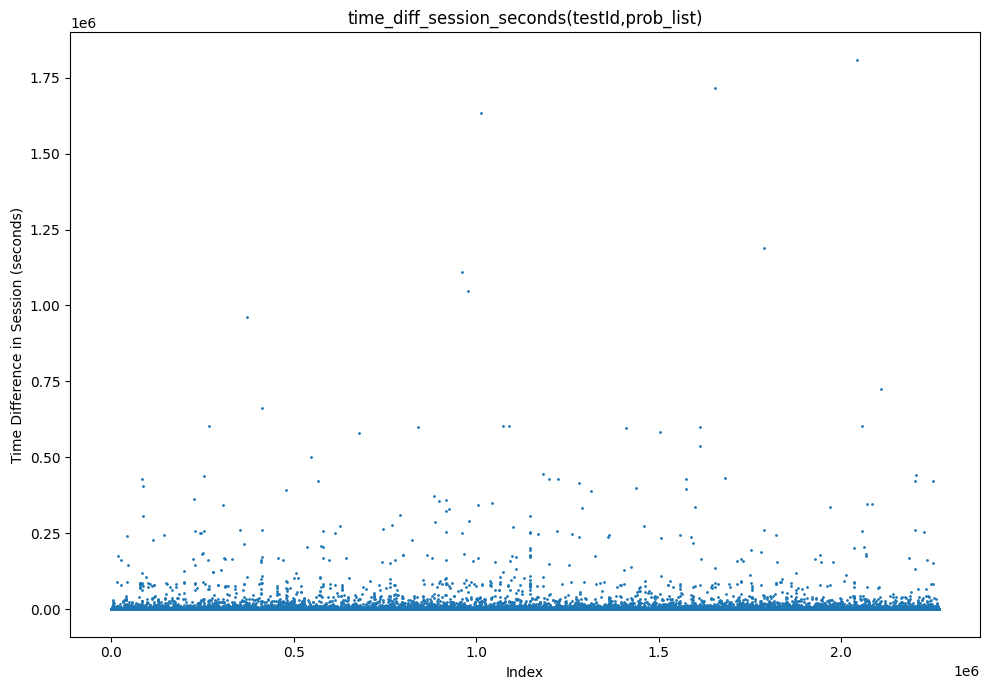

In [21]:
import matplotlib.pyplot as plt

# timedelta를 초 단위로 변환
time_diff_session_seconds = temp_df['time_diff_session'].dt.total_seconds()

fig, ax = plt.subplots(1, 1, figsize=(10, 7))  # 1행 1열의 subplot 생성

# # 산점도 그리기
# ax[0].scatter(temp_df.index, time_diff_seconds,s=1)
# ax[0].set_xlabel('Index')
# ax[0].set_ylabel('Time Difference (seconds)')
# ax[0].set_title('time_diff_seconds')

ax.scatter(temp_df.index, time_diff_session_seconds,s=1)
ax.set_xlabel('Index')
ax.set_ylabel('Time Difference in Session (seconds)')
ax.set_title('time_diff_session_seconds(testId,prob_list)')

plt.tight_layout()
plt.show()

In [23]:
ver1_temp_df=temp_df

### ver2. 기준 {1,2,3} 사용
15 분을 기준 시간으로 사용한 이유는 상위 1% 이상치를 거르기 위해 사용했다.

In [50]:
quantiles = ver1_temp_df['time_diff_session'].quantile([0.8,0.85,0.9,0.95,0.99,1]) #.dt.total_seconds()
quantiles

0.80    0 days 00:01:21
0.85    0 days 00:01:46
0.90    0 days 00:02:30
0.95    0 days 00:04:20
0.99    0 days 00:15:48
1.00   20 days 22:27:27
Name: time_diff_session, dtype: timedelta64[ns]

In [8]:
%%time
temp_df = df.copy()
temp_df['order_of_prob']=temp_df['assessmentItemID'].apply(lambda x: x[7:]).astype(int)
temp_df['time_diff']= temp_df['Timestamp'].diff(-1).abs()
before_testId = '0'
before_userID = 0
before_time = ''
sess_start =0
prob_list=[]
temp_df['solving_session']=0
for i,row in temp_df.iterrows():
    if  before_testId != row['testId'] or row['order_of_prob'] in prob_list or before_time > pd.Timedelta('15 minutes'):
        before_testId=row['testId']
        prob_list=[]
        sess_start+=1
    temp_df.at[i, 'solving_session'] = sess_start
    before_time = row['time_diff']
    prob_list.append(row['order_of_prob'])

CPU times: user 1min 43s, sys: 939 ms, total: 1min 44s
Wall time: 1min 44s


In [9]:
temp_df['order_of_solving'] = temp_df.groupby('solving_session').cumcount() + 1
temp_df['time_diff_session']= temp_df.groupby('solving_session')['Timestamp'].diff(-1).abs()
temp_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,order_of_prob,time_diff,solving_session,order_of_solving,time_diff_session
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,0 days 00:00:03,1,1,0 days 00:00:03
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,2,0 days 00:00:08,1,2,0 days 00:00:08
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,3,0 days 00:00:07,1,3,0 days 00:00:07
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,4,0 days 00:00:07,1,4,0 days 00:00:07
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,5,0 days 00:00:11,1,5,0 days 00:00:11
...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,5,76 days 18:16:18,394989,5,NaT
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,0 days 00:00:11,394990,1,0 days 00:00:11
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2,0 days 00:00:46,394990,2,0 days 00:00:46
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,3,0 days 00:01:13,394990,3,0 days 00:01:13


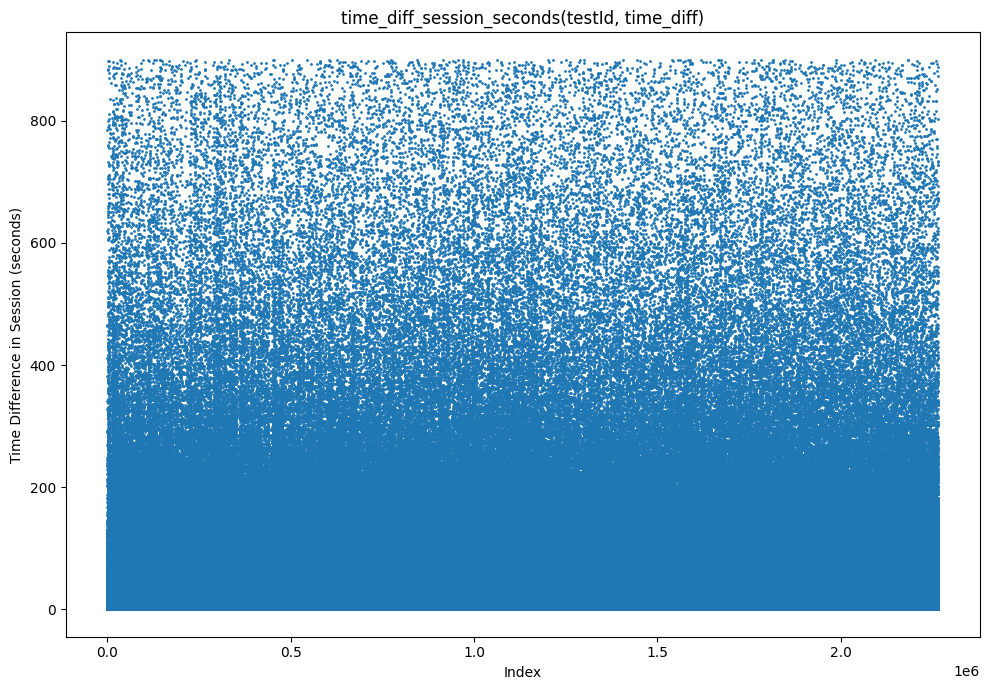

In [33]:
import matplotlib.pyplot as plt

# timedelta를 초 단위로 변환
time_diff_session_seconds = temp_df['time_diff_session'].dt.total_seconds()

fig, ax = plt.subplots(1, 1, figsize=(10, 7))  # 1행 1열의 subplot 생성

# # 산점도 그리기
# ax[0].scatter(temp_df.index, time_diff_seconds,s=1)
# ax[0].set_xlabel('Index')
# ax[0].set_ylabel('Time Difference (seconds)')
# ax[0].set_title('time_diff_seconds')

ax.scatter(temp_df.index, time_diff_session_seconds,s=1)
ax.set_xlabel('Index')
ax.set_ylabel('Time Difference in Session (seconds)')
ax.set_title('time_diff_session_seconds(testId, time_diff)')

plt.tight_layout()
plt.show()

In [34]:
ver2_temp_df=temp_df

## 문항 풀이 순서에 따른 정답률

In [43]:
baseline_df = ver1_temp_df #ver1_temp_df
solvorder_group=baseline_df.groupby(baseline_df['order_of_solving']).agg({
    'userID': 'count',
    'answerCode': percentile
})
solvorder_group.sort_values(by = 'answerCode' , ascending=False)

,userID,answerCode
order_of_solving,,
1,374883,0.750322
2,373476,0.720456
3,372456,0.689472
4,370228,0.662395
5,356982,0.598490
6,197484,0.553402
10,5302,0.523765
7,125341,0.511461
9,17804,0.476466


## 풀이 소요시간 범주화
'time_diff_session' 컬럼의 describe() 결과를 기반으로 범주를 설정했다.

In [24]:
baseline_df = ver1_temp_df #ver1_temp_df

In [51]:
baseline_df['time_diff_session'].describe()

count                      1891703
mean     0 days 00:02:14.869694661
std      0 days 01:06:48.065448115
min                0 days 00:00:00
25%                0 days 00:00:10
50%                0 days 00:00:27
75%                0 days 00:01:05
max               20 days 22:27:27
Name: time_diff_session, dtype: object

In [26]:
# 데이터에 소요시간 추가하는 코드
temp_df = df.copy()
temp_df['3_sec']=0
temp_df['5_sec']=0
temp_df['10_sec']=0
temp_df['22_sec']=0
temp_df['30_sec']=0
temp_df['1_min']=0
temp_df['5_min']=0
temp_df['10_min']=0
temp_df['more_10_min']=0
temp_df['nan']=0
for i,row in baseline_df.iterrows():
    if row['time_diff_session']<=pd.Timedelta('3 seconds'):
        temp_df.at[i,'3_sec']=1
    elif row['time_diff_session']<=pd.Timedelta('5 seconds'):
        temp_df.at[i,'5_sec']=1
    elif row['time_diff_session']<=pd.Timedelta('10 seconds'):
        temp_df.at[i,'10_sec']=1
    elif row['time_diff_session']<=pd.Timedelta('22 seconds'):
        temp_df.at[i,'22_sec']=1
    elif row['time_diff_session']<=pd.Timedelta('30 seconds'):
        temp_df.at[i,'30_sec']=1
    elif row['time_diff_session']<=pd.Timedelta('1 minutes'):
        temp_df.at[i,'1_min']=1
    elif row['time_diff_session']<=pd.Timedelta('5 minutes'):
        temp_df.at[i,'5_min']=1
    elif row['time_diff_session']<=pd.Timedelta('10 minutes'):
        temp_df.at[i,'10_min']=1
    elif row['time_diff_session'] > pd.Timedelta('10 minutes'):
        temp_df.at[i,'more_10_min']=1
    else:
        temp_df.at[i,'nan']=1
temp_df      

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,order_of_prob,3_sec,5_sec,10_sec,22_sec,30_sec,1_min,5_min,10_min,more_10_min,nan
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,001,1,0,0,0,0,0,0,0,0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,002,0,0,1,0,0,0,0,0,0,0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,003,0,0,1,0,0,0,0,0,0,0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,004,0,0,1,0,0,0,0,0,0,0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,005,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,005,0,0,0,0,0,0,0,0,0,1
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,001,0,0,0,1,0,0,0,0,0,0
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,002,0,0,0,0,0,1,0,0,0,0
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,003,0,0,0,0,0,0,1,0,0,0


In [28]:
print('Count / 정답률')
sums={}
means={}
for time in ['3_sec','5_sec','10_sec','22_sec','30_sec','1_min','5_min','10_min','more_10_min','nan']:
    print(time,':',sum(temp_df[time]),'/',temp_df[temp_df[time]==1]['answerCode'].mean())
    sums[time]=sum(temp_df[time])
    means[time]=temp_df[temp_df[time]==1]['answerCode'].mean()

Count / 정답률
3_sec : 246822 / 0.2543614426590822
5_sec : 87024 / 0.3237152969295826
10_sec : 153168 / 0.6203188655593858
22_sec : 349955 / 0.7714248974868197
30_sec : 177341 / 0.7868964311693292
1_min : 370647 / 0.7817734933777961
5_min : 428135 / 0.7694465530732129
10_min : 45976 / 0.7491082303810683
more_10_min : 32635 / 0.7381645472652061
nan : 374883 / 0.5601907795232113


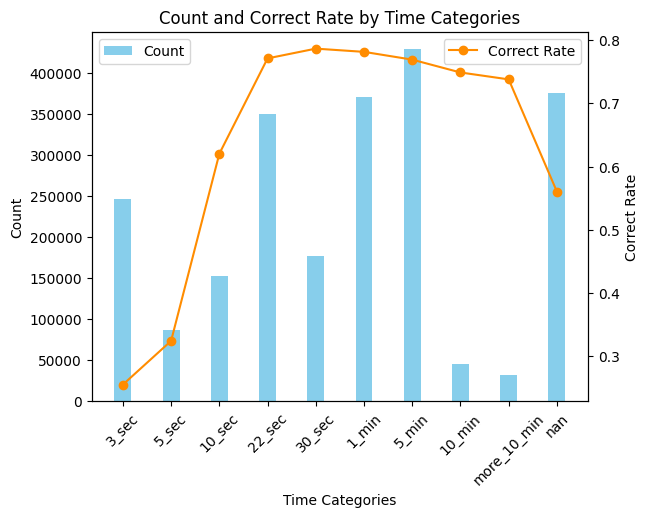

In [30]:
fig, ax1 = plt.subplots()

# 막대 그래프를 위한 x축 위치
ind = np.arange(len(sums))

# 막대 그래프
ax1.bar(ind, sums.values(), width=0.35, label='Count', color='skyblue')

# 막대 그래프 설정
ax1.set_xlabel('Time Categories')
ax1.set_ylabel('Count')
ax1.set_xticks(ind)
ax1.set_xticklabels(sums.keys(),rotation=45)
ax1.legend(loc='upper left')

# 선 그래프를 위한 두 번째 y축 설정
ax2 = ax1.twinx()

# 선 그래프
ax2.plot(ind, means.values(), label='Correct Rate', color='darkorange', marker='o')

# 선 그래프 설정
ax2.set_ylabel('Correct Rate')
ax2.legend(loc='upper right')

# 타이틀 설정
plt.title('Count and Correct Rate by Time Categories')

# 그래프 표시
plt.show()


## 시험지(세션)별 풀이 시간 

## 시험지(세션)별 소요 시간

In [13]:
temp_df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'order_of_prob', 'time_diff', 'solving_session',
       'order_of_solving', 'time_diff_session'],
      dtype='object')

In [29]:
time_diff_group=temp_df.groupby('solving_session')['time_diff_session'].sum()

In [30]:
time_diff_group


solving_session
1        0 days 00:00:36
2        0 days 00:02:08
3        0 days 00:02:56
4        0 days 00:10:31
5        0 days 00:03:04
               ...      
394986   0 days 00:01:33
394987   0 days 00:02:18
394988   0 days 00:01:35
394989   0 days 00:03:40
394990   0 days 00:02:10
Name: time_diff_session, Length: 394990, dtype: timedelta64[ns]

In [31]:
time_diff_group.describe()

count                       394990
mean     0 days 00:04:35.995156839
std      0 days 00:05:10.567876762
min                0 days 00:00:00
25%                0 days 00:01:19
50%                0 days 00:02:53
75%                0 days 00:05:56
max                0 days 01:08:36
Name: time_diff_session, dtype: object

In [32]:
quantiles = time_diff_group.quantile([0.8,0.85,0.9,0.95,0.99,1]) #.dt.total_seconds()
quantiles

0.80   0 days 00:07:05
0.85   0 days 00:08:40
0.90   0 days 00:11:04
0.95   0 days 00:15:14
0.99   0 days 00:24:41
1.00   0 days 01:08:36
Name: time_diff_session, dtype: timedelta64[ns]

## 문제 풀이 시작 시간

In [97]:
temp_df= df.copy()
def calculate_time(dt):
    total_seconds = dt.hour * 3600 + dt.minute * 60 + dt.second
    return np.sin(np.pi * total_seconds / (24 * 3600))

temp_df['solving_start_time'] = temp_df['Timestamp'].apply(calculate_time)
# 시험지 풀이 요일과 주말 여부
temp_df['solving_day'] = temp_df['Timestamp'].dt.weekday+1
temp_df['solving_is_weekend']= temp_df['solving_day'].apply(lambda x: 2 if x >= 6 else 1)

In [105]:
temp_df['solving_start_time_r3']=temp_df['solving_start_time'].round(3)
temp_df['solving_start_time_r2']=temp_df['solving_start_time'].round(2)

In [110]:
# 'solving_start_time' 별로 그룹화 후 count 및 정답률 계산
grouped = temp_df.groupby('solving_start_time')['answerCode'].agg(['count','mean'])
grouped_r3 = temp_df.groupby('solving_start_time_r3')['answerCode'].agg(['count','mean'])
grouped_r2 = temp_df.groupby('solving_start_time_r2')['answerCode'].agg(['count','mean'])

### 오리지널

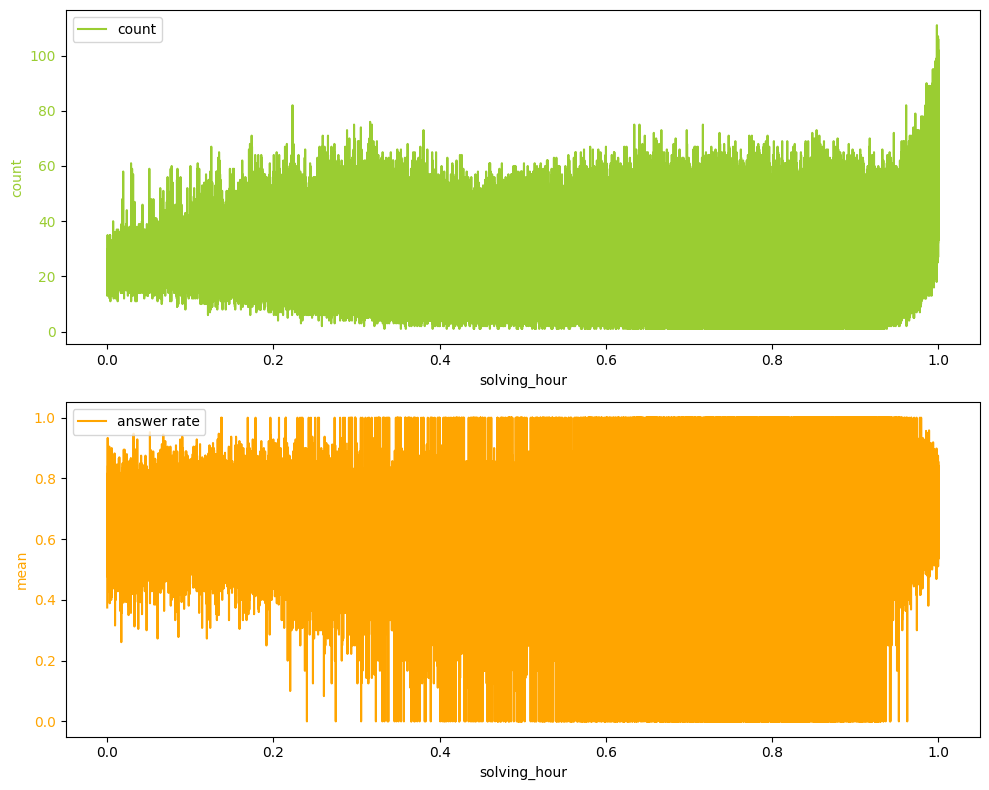

In [102]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

#(count)
color = 'yellowgreen'
ax[0].set_xlabel('solving_hour')
ax[0].set_ylabel('count', color=color)
ax[0].plot(grouped.index, grouped['count'], color=color, label='count')
ax[0].tick_params(axis='y', labelcolor=color)
ax[0].legend(loc='upper left')

# (mean)
color = 'orange'
ax[1].set_xlabel('solving_hour')
ax[1].set_ylabel('mean', color=color)
ax[1].plot(grouped.index, grouped['mean'], color=color, label='answer rate')
ax[1].tick_params(axis='y', labelcolor=color)
ax[1].legend(loc='upper left')

fig.tight_layout()
plt.show()

### 소수점 셋째 자리 반올림

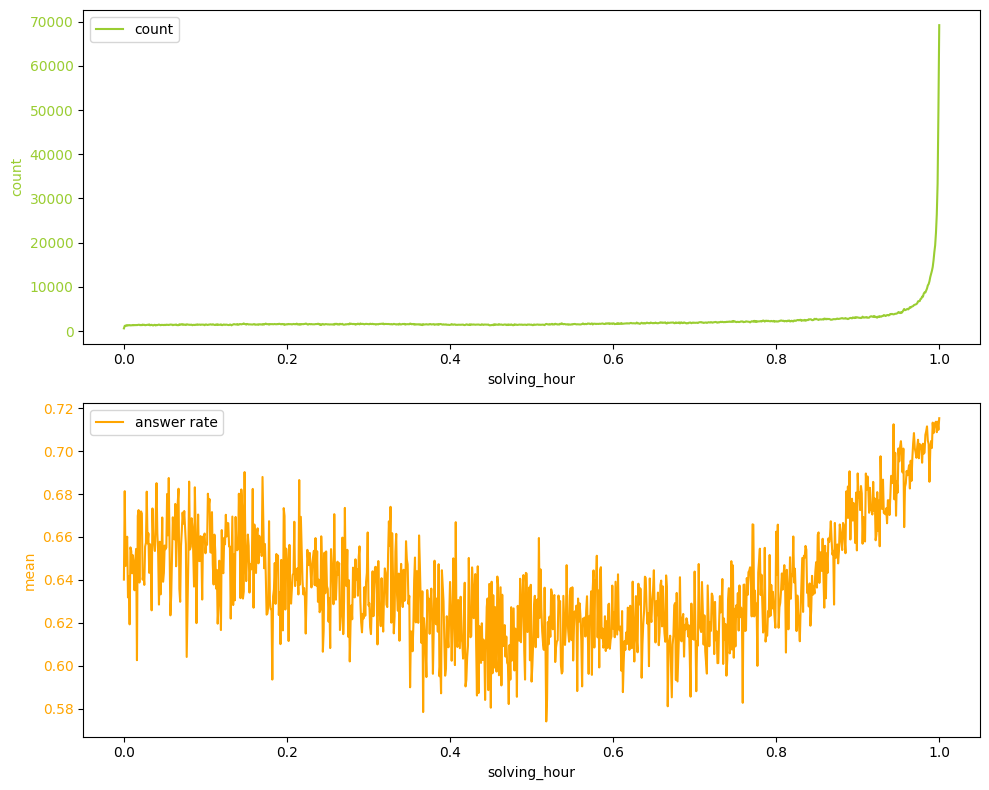

In [109]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

#(count)
color = 'yellowgreen'
ax[0].set_xlabel('solving_hour')
ax[0].set_ylabel('count', color=color)
ax[0].plot(grouped_r3.index, grouped_r3['count'], color=color, label='count')
ax[0].tick_params(axis='y', labelcolor=color)
ax[0].legend(loc='upper left')

# (mean)
color = 'orange'
ax[1].set_xlabel('solving_hour')
ax[1].set_ylabel('mean', color=color)
ax[1].plot(grouped_r3.index, grouped_r3['mean'], color=color, label='answer rate')
ax[1].tick_params(axis='y', labelcolor=color)
ax[1].legend(loc='upper left')

fig.tight_layout()
plt.show()

### 소수점 둘째 자리 반올림

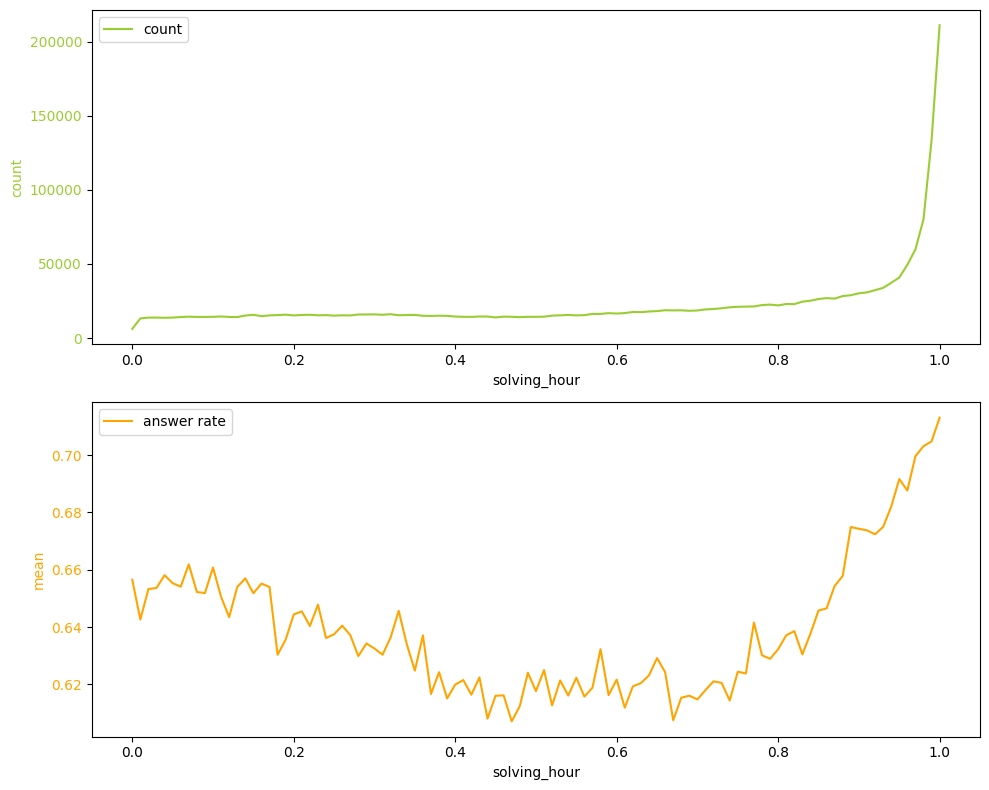

In [112]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

#(count)
color = 'yellowgreen'
ax[0].set_xlabel('solving_hour')
ax[0].set_ylabel('count', color=color)
ax[0].plot(grouped_r2.index, grouped_r2['count'], color=color, label='count')
ax[0].tick_params(axis='y', labelcolor=color)
ax[0].legend(loc='upper left')

# (mean)
color = 'orange'
ax[1].set_xlabel('solving_hour')
ax[1].set_ylabel('mean', color=color)
ax[1].plot(grouped_r2.index, grouped_r2['mean'], color=color, label='answer rate')
ax[1].tick_params(axis='y', labelcolor=color)
ax[1].legend(loc='upper left')

fig.tight_layout()
plt.show()

## 문제 풀이 요일

In [115]:
grouped_day = temp_df.groupby('solving_day')['answerCode'].agg(['count','mean'])
grouped_day

,count,mean
solving_day,,
1,319248,0.676518
2,458988,0.667046
3,378148,0.641011
4,444433,0.658466
5,387283,0.643362
6,155330,0.603206
7,123156,0.675257


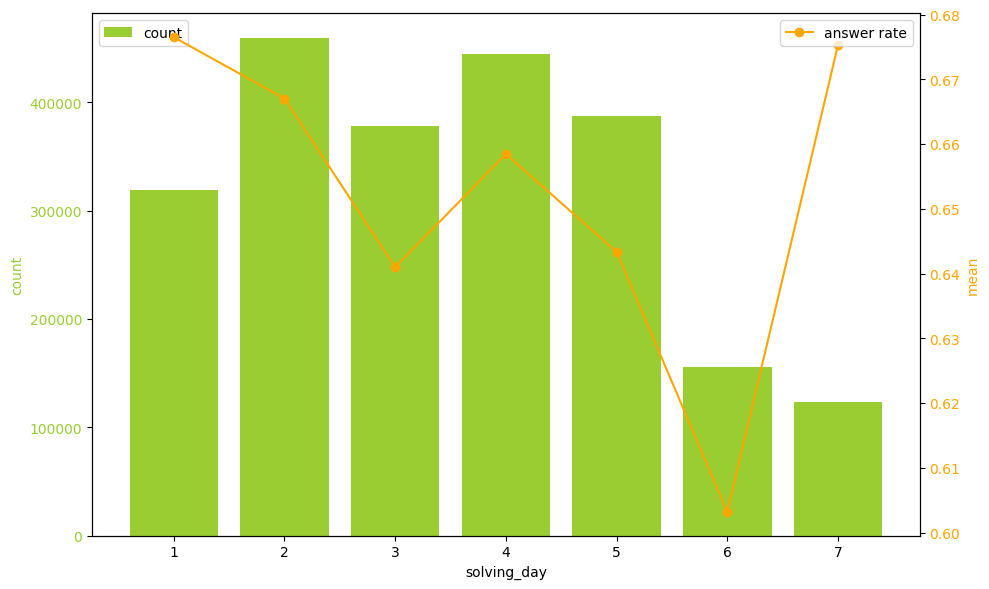

In [118]:
# 그래프 그리기 - 1개의 서브플롯 생성, 두 개의 y축 사용
fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 y축 (count)
color = 'yellowgreen'
ax1.set_xlabel('solving_day')
ax1.set_ylabel('count', color=color)
ax1.bar(grouped_day.index, grouped_day['count'], color=color, label='count')
ax1.tick_params(axis='y', labelcolor=color)

# 두 번째 y축 생성 (mean)
ax2 = ax1.twinx()  # 동일한 x축을 공유하는 두 번째 y축 생성
color = 'orange'
ax2.set_ylabel('mean', color=color)
ax2.plot(grouped_day.index, grouped_day['mean'], color=color, label='answer rate', marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# 레전드 추가
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()  # 레이아웃 조정
plt.show()

### 문제 풀이 요일 -> 주말 여부

In [120]:
grouped_weekend = temp_df.groupby('solving_is_weekend')['answerCode'].agg(['count','mean'])
grouped_weekend

,count,mean
solving_is_weekend,,
1,1988100,0.657083
2,278486,0.635070


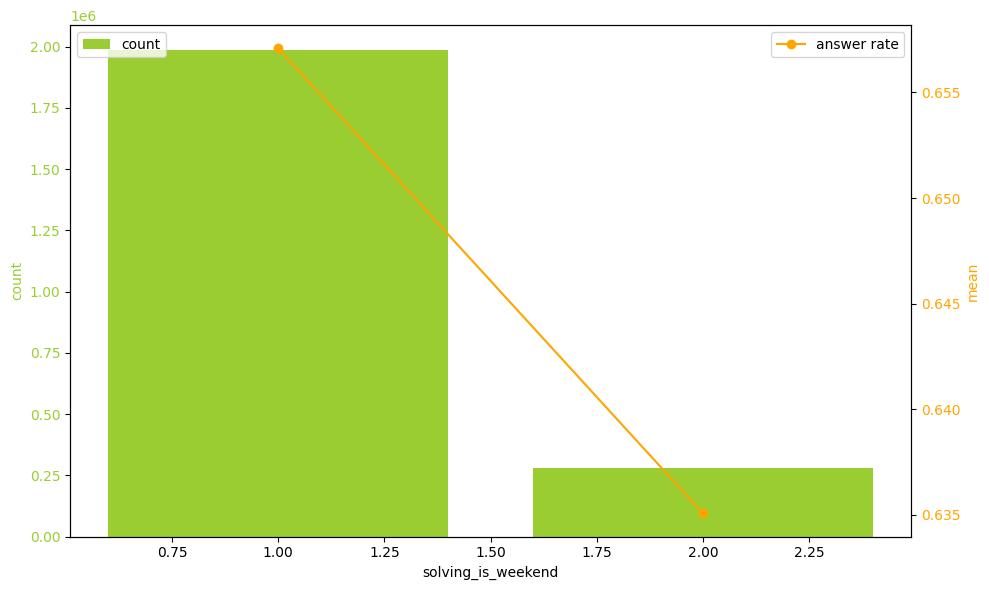

In [121]:
# 그래프 그리기 - 1개의 서브플롯 생성, 두 개의 y축 사용
fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 y축 (count)
color = 'yellowgreen'
ax1.set_xlabel('solving_is_weekend')
ax1.set_ylabel('count', color=color)
ax1.bar(grouped_weekend.index, grouped_weekend['count'], color=color, label='count')
ax1.tick_params(axis='y', labelcolor=color)

# 두 번째 y축 생성 (mean)
ax2 = ax1.twinx()  # 동일한 x축을 공유하는 두 번째 y축 생성
color = 'orange'
ax2.set_ylabel('mean', color=color)
ax2.plot(grouped_weekend.index, grouped_weekend['mean'], color=color, label='answer rate', marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# 레전드 추가
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()  # 레이아웃 조정
plt.show()

# 데이터 특이사항
TimeStamp 사용을 위해 데이터를 보면서 발견한 특이 사항들

### 반대로 푸는 경우

In [44]:
df[((df['userID']==0)&(df['testId']=='A080000044'))]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,order_of_prob
339,0,A080044008,A080000044,1,2020-06-27 01:54:34,4783,008
340,0,A080044007,A080000044,0,2020-06-27 01:54:40,4801,007
341,0,A080044006,A080000044,0,2020-06-27 01:54:43,4799,006
342,0,A080044005,A080000044,0,2020-06-27 01:54:47,4799,005
343,0,A080044004,A080000044,0,2020-06-27 01:54:52,4797,004
344,0,A080044003,A080000044,0,2020-06-27 01:54:54,4799,003
345,0,A080044001,A080000044,1,2020-06-27 01:54:57,4784,001
346,0,A080044002,A080000044,0,2020-06-27 01:55:00,4784,002


### 1번을 늦게 푸는 경우

In [47]:
df[((df['userID']==2181)&(df['testId']=='A080000129'))|((df['userID']==2182)&(df['testId']=='A080000001'))]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,order_of_prob
1341323,2181,A080129001,A080000129,1,2020-12-22 22:13:14,2723,001
1341324,2181,A080129002,A080000129,0,2020-12-22 22:15:13,2723,002
1341325,2181,A080129003,A080000129,1,2020-12-22 22:16:24,2725,003
1341326,2181,A080129004,A080000129,0,2020-12-22 22:16:26,2725,004
1341327,2181,A080129005,A080000129,0,2020-12-22 22:16:29,2725,005
1341328,2181,A080129006,A080000129,0,2020-12-22 22:16:33,2725,006
1341329,2182,A080001002,A080000001,1,2020-01-04 03:50:05,1356,002
1341330,2182,A080001003,A080000001,1,2020-01-04 03:50:26,1396,003
1341331,2182,A080001004,A080000001,0,2020-01-04 03:50:48,4604,004
1341332,2182,A080001001,A080000001,1,2020-01-04 03:50:53,4604,001


### 시험지를 바꿔가면서 푸는 경우

In [48]:
df[((df['userID']==23)&(df['testId']=='A080000083'))|((df['userID']==23)&(df['testId']=='A070000097'))]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,order_of_prob
15939,23,A080083001,A080000083,1,2020-08-18 23:33:16,32,001
15940,23,A070097001,A070000097,0,2020-08-18 23:39:38,8895,001
15941,23,A080083002,A080000083,1,2020-08-18 23:39:43,32,002
15942,23,A070097002,A070000097,1,2020-08-18 23:40:06,8893,002
15943,23,A070097003,A070000097,1,2020-08-18 23:40:18,8894,003
15944,23,A080083003,A080000083,1,2020-08-18 23:40:18,32,003
15945,23,A070097004,A070000097,1,2020-08-18 23:41:26,8894,004
15946,23,A070097005,A070000097,0,2020-08-18 23:42:44,8894,005
15947,23,A070097006,A070000097,1,2020-08-18 23:44:00,8894,006
15948,23,A070097007,A070000097,0,2020-08-18 23:45:09,8894,007
